$$
\frac{d \vec{v}}{dt} = \frac{1}{r^3} \left[-M \vec{r} + \vec{v}\times\vec{S} - \frac{3 (\vec{S}\cdot\vec{r})}{r^2} \vec{v}\times\vec{r}\right]
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import scipy.integrate as spint
import scipy.interpolate as spinter
from multiprocessing import Process, shared_memory, cpu_count
import lense_thirring_tools as ltt

# setup grid and simulation params for spacetime sim

In [ ]:
num_threads = cpu_count()
coll_name = "newton"
setup = {
    "spawn_pos": [0, 0, 0],
    "spawn_vel": [0, 0, 0],
    "grid_size": [12, 12, 12],
    "num_lines": [6, 6, 6],
    "subdivisions": 300,
    "simplified_subd" : 150,
    "tau_max": 10.0,
    "tau_evals": 200,
    "error": 1e-7,
    "M": 1.0,
    "R": 1.0,
    "omega": 0,#1e1*np.pi,
}

def f(x):
    std = 0.8
    return 0.2*(np.exp(-((x+2.6)/std)**2) + 10*np.exp(-np.abs((x)/0.06)) + np.exp(-((x-2.6)/std)**2)) + 0.024
    #return 1.0

def get_geodesic(tau_max, z0, t_evals, tol=1e-6):
    taus,zs = ltt.get_geodesic(tau_max=tau_max,z0=z0,tol=tol,accF=ltt.acc_lense_thirring,check_break=ltt.check_break)
    zs = zs.T
    intf = spinter.interp1d(taus, zs, fill_value=(
        zs[:, 0], zs[:, -1]), bounds_error=False)
    return intf(t_evals)

# calculate trajectories

In [ ]:
M = setup["M"]
R = setup["R"]
omega = setup["omega"]
S = 2.0/5.0 * M * R**2 * setup["omega"]
ltt.set_params_lense_thirring(mass=M, omega=omega, radius=R)

lines = ltt.generate_3d_grid_lines(np.array(setup["spawn_pos"])-np.array(setup["grid_size"])/2, np.array(
    setup["spawn_pos"])+np.array(setup["grid_size"])/2, setup["num_lines"], setup["subdivisions"], f)
print(f"using gridlines: {lines.shape}")
print("simulating...")

taus = np.linspace(0, setup["tau_max"], setup["tau_evals"])
line_ev = np.empty((len(lines), len(taus), len(lines[0]), 3), np.float64)

def simulate_lines(lis, shmn):
    global setup, taus, lines
    existing_shm = shared_memory.SharedMemory(name=shmn)
    line_ev = np.ndarray((len(lines), len(taus), len(
        lines[0]), 3), dtype=np.float64, buffer=existing_shm.buf)
    for li in lis:
        for pi, pnt in enumerate(lines[li]):
            z0 = np.array([0, pnt[0], pnt[1], pnt[2], 1, setup["spawn_vel"]
                           [0], setup["spawn_vel"][1], setup["spawn_vel"][2]])
            zs = get_geodesic(setup["tau_max"], z0, taus, setup["error"])
            line_ev[li, :, pi, :] = zs[1:4].T


shm = shared_memory.SharedMemory(create=True, size=line_ev.nbytes)
sh_lines = np.ndarray(line_ev.shape, dtype=line_ev.dtype, buffer=shm.buf)
sh_lines[:, :, :, :] = np.zeros_like(line_ev)

ts = []
for thread_i in range(num_threads):
    lis = np.arange(thread_i, len(lines), num_threads)
    ts.append(Process(target=simulate_lines, args=[lis, shm.name]))
    ts[-1].start()

for t in ts:
    t.join()

using gridlines: (108, 300, 3)
simulating...


# simplify and save lines

In [137]:
def simplify_line(l0,subd):
    bl0 = np.append([0], np.sqrt(np.sum((l0[1:]-l0[:-1])**2,axis=1)),axis=0)
    bl0 = np.cumsum(bl0)
    ifunc = spinter.interp1d(bl0, l0.T, fill_value=(
        l0[0, :], l0[-1, :]), bounds_error=False)
    return ifunc(np.linspace(bl0[0],bl0[-1],subd)).T

In [138]:
timesteps = sh_lines.shape[1]
line_nums = sh_lines.shape[0]

lines = np.empty((line_nums, timesteps, setup["simplified_subd"],3))
for li in range(line_nums):
    for ti in range(timesteps):
        lines[li,ti,:,:] = simplify_line(sh_lines[li,ti,:,:],setup["simplified_subd"])

subdivisions = lines.shape[2]
print(f"lines:({lines.shape}), timesteps={timesteps}, line_nums={line_nums}, subdivisions={subdivisions}")

lines:((108, 200, 150, 3)), timesteps=200, line_nums=108, subdivisions=150


In [139]:
np.save(f'./assets/spacetime_sims/{coll_name}_lines__line_nums={line_nums}__subdivisions={subdivisions}__timesteps={timesteps}__tau_max={setup["tau_max"]}__R={setup["R"]}__M={setup["M"]}__omega={setup["omega"]}.npy', lines)

# (optional) load lines

In [16]:
lines = np.load(f'./assets/spacetime_sims/{"lense-thirring"}_lines__line_nums={108}__subdivisions={150}__timesteps={200}__tau_max={10.0}__R={1.0}__M={1.0}__omega={31.41592653589793}.npy')
taus = np.linspace(0, 10, 200)

# plot lines

In [17]:
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

fig.subplots_adjust(bottom=0.25)

ax.set_aspect('equal')
lim = 6
ax.set(xlim=[-lim,lim], ylim=[-lim,lim], zlim3d=[-lim,lim], xlabel=r'x', ylabel=r'y')
ax.view_init(elev=10., azim=(-100))

line_objs = []
for line in lines[:,0,:,:]:
    pnts = line.T
    [line_obj] = ax.plot(pnts[0],pnts[1],pnts[2],color="k",zorder=10)
    line_objs.append(line_obj)

tau_slider_ax  = fig.add_axes([0.25, 0.15, 0.65, 0.03])
tau_slider = Slider(tau_slider_ax, 'tau idx', 0, len(taus)-1, valstep=1, valinit=0)

angle_slider_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
angle_slider = Slider(angle_slider_ax, 'angle', 0, 360, valinit=0)

def tau_on_changed(val):
    tau_idx = tau_slider.val
    tau = taus[tau_idx]
    fig.suptitle(rf'$\tau={tau:0.2f}$')
    for li,line in enumerate(lines[:,tau_idx,:,:]):
        line_objs[li].set_data_3d(lines[li,tau_idx,:,:].T)
    fig.canvas.draw_idle()
def angle_on_changed(val):
    angle = angle_slider.val
    ax.view_init(elev=10., azim=(-angle-100))
    fig.canvas.draw_idle()
tau_slider.on_changed(tau_on_changed)
angle_slider.on_changed(angle_on_changed)

plt.show()

# calculate and plot a single Trajectory

In [14]:
ltt.set_params_lense_thirring(mass=0.22,omega=0.15,radius=1)

In [47]:
ltt.S = 0

In [42]:
%matplotlib qt
z0 = np.array([0,2,1e-2,0,1,-8e-1,0,0])
ts,ps = ltt.get_geodesic(40,z0,tol=1e-10,check_break=None)
trajs = [ps[:,1:4]]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.subplots_adjust(bottom=0.25)
ax.set_aspect('equal')
lim = 2
c = [0,0,0]
ax.set(xlim=[-lim+c[0],lim+c[0]], ylim=[-lim+c[1],lim+c[1]], zlim3d=[-lim+c[2],lim+c[2]], xlabel=r'x', ylabel=r'y')
ax.view_init(elev=90., azim=(-90))

def draw_sphere(phase=0.0, radius=1.0):
    u, v = np.mgrid[0:2*np.pi:14j, 0:np.pi:7j]
    x = radius*np.cos(u+phase)*np.sin(v)
    y = radius*np.sin(u+phase)*np.sin(v)
    z = radius*np.cos(v)
    return ax.plot_surface(x, y, z, color="red", zorder=-10)

#sphere = draw_sphere(0,1)
for ps in trajs:
    ax.plot(ps[:,0],ps[:,1],ps[:,2],marker=".")
plt.show()

# compute t(l) and x(l) from a set of ts & xs

In [32]:
class ParametricCurve:
    """
    Class to handle operations on a parametrized curve
    """

    def __init__(self, ts, xs=None, xf=None, init_nat_param=True):
        self.ts = ts
        self.tmax = np.max(ts)
        self.tmin = np.min(ts)
        if xf is not None:
            self.xs = xf(ts)
        elif xs is not None:
            self.xs = xs
        else:
            raise Exception("either xs or xf has to be given")
        if init_nat_param:
            self.init_natural_parametrization()
    
    def init_natural_parametrization(self):
        l = np.append([0], np.sqrt(np.sum((self.xs[1:]-self.xs[:-1])**2,axis=1)),axis=0)
        l = np.cumsum(l)
        self.length = np.max(l)
        self.l_of_t = spinter.interp1d(self.ts, l, fill_value=(
            l[0], l[-1]), bounds_error=False, axis=0)
        self.t_of_l = spinter.interp1d(l, self.ts, fill_value=(
            self.ts[0], self.ts[-1]), bounds_error=False, axis=0)
        self.x_of_l = spinter.interp1d(l, self.xs, fill_value=(
            self.xs[0], self.xs[-1]), bounds_error=False, axis=0)
        #self.x_of_t = spinter.interp1d(self.ts, self.xs, fill_value=(
        #    self.xs[0], self.xs[-1]), bounds_error=False, axis=0)
        vs = np.gradient(l, self.ts)
        self.vmax = np.max(vs)
        self.vmin = np.min(vs)
        self.v_of_l = spinter.interp1d(l, vs, fill_value=(
            vs[0], vs[-1]), bounds_error=False, axis=0)
    
    def get_section_by_l(self, lstart, lend, seg_size=None):
        """
        returns an array of equally spaced l values from lstart to lend with approx segment size of seg_size
        """
        if seg_size is None:
            seg_size = self.length/100
        return np.linspace(lstart, lend, int((lend-lstart)/seg_size))
    
    def get_section_by_t(self, tstart, tend, seg_size=None):
        """
        returns an array of equally spaced l values corresponding to values from tstart to tend with approx segment size of seg_size
        """
        return self.get_section_by_l(self.l_of_t(tstart), self.l_of_t(tend), seg_size=seg_size)

In [37]:
ts = np.linspace(0,1,100)
ts = 2*np.pi*ts**4 - np.pi
xs = np.array([[np.sin(t), np.cos(t), t**3] for t in ts])

c = ParametricCurve(ts, xs=xs)
lev = c.get_section_by_t(-1, np.pi, 0.1)
tev = c.t_of_l(lev)
xev = c.x_of_l(lev)
vev = c.v_of_l(lev)

In [38]:
%matplotlib qt
ps = xev

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

fig.subplots_adjust(bottom=0.25)

ax.set_aspect('equal')
lim = 2
ax.set(xlim=[-lim,lim], ylim=[-lim,lim], zlim3d=[-lim,lim], xlabel=r'x', ylabel=r'y')
ax.view_init(elev=10., azim=(-100))

ax.scatter(ps[:,0],ps[:,1],ps[:,2],marker=".",c=vev,cmap="viridis")
plt.show()

In [ ]:
class StreamLines(VGroup):
    """
    startPos is a (N,D) array, where N is the number of streamlines and D is the number of dimensions (e.g.: 3)
    fieldFunc is the function f(t,x)->dx/dt where x is of dimension D
    """
    def __init__(self,
                 startPos,
                 fieldFunc,
                 t_max,
                 tN=200,
                 tol=1e-5,
                 showRatio=0.2,
                 showSegments=2,
                 scaleF=1.0,
                 cmap="viridis",
                 cfunc=lambda x,r: r,
                 depth_test=True,
                 rand_init_t=True):
        self.startPos = startPos
        self.fieldFunc = fieldFunc
        self.t_max = t_max
        self.rtol = tol
        self.atol = tol*1e-2
        self.tN = tN
        self.showN = int(tN*showRatio)
        self.streamlineNum = startPos.shape[0]
        self.scaleF = scaleF
        self.cmap = get_color_map(cmap)
        self.currentT = 0.0
        self.showSegments = showSegments
        self.cfunc = cfunc
        if rand_init_t:
            self.dt_rand = np.random.uniform(size=(self.streamlineNum))
        else:
            self.dt_rand = np.zeros((self.streamlineNum))
        #super().__init__()
        super().__init__([VGroup([VMobject() for j in range(self.showSegments)]) for i in range(self.streamlineNum)])
        if depth_test:
            self.apply_depth_test(recurse=True)
    
    def startUpdating(self, timeScaleF=1.0):
        self.currentT = 0.0
        def updater(obj,dt):
            nonlocal timeScaleF
            obj.currentT += dt*timeScaleF
            obj.updateVMobjs(obj.currentT)
        self.add_updater(updater,call=True)
    
    def stopUpdating(self):
        self.clear_updaters()

    def updateVMobjs(self, t, fadeIn=True,fadeOut=True):
        startTs, endTs = self.getSegmentBoundsAtTime(t,fadeIn=fadeIn,fadeOut=fadeOut)

        for li in range(self.streamlineNum):
            for si in range(self.showSegments):
                if endTs[li][si]-startTs[li][si] >= 2:
                    self[li][si].set_points_as_corners(self.lines[li,startTs[li][si]:endTs[li][si],:]*self.scaleF)
                    self[li][si].set_stroke(color=self.pnt_cols[li][startTs[li][si]:endTs[li][si]])
                else:
                    self[li][si].set_points_as_corners([])
  
    def getSegmentBoundsAtTime(self,t,fadeIn=True,fadeOut=True):
        fI = 0
        fO = 0
        if fadeIn:
            fI = self.showN
        if fadeOut:
            fO = self.showN
        startTs = [[int((self.tN-1+fI-self.showN+fO)*((t/self.t_max+di/self.showSegments + dt)%1.0))-fI for di in np.arange(0,self.showSegments,1)] for dt in self.dt_rand]
        endTs = [[startT+self.showN for startT in startTs[li]] for li in range(self.streamlineNum)]
        return np.clip(startTs, 0, self.tN-1), np.clip(endTs, 0, self.tN-1)

    def computeLines(self):
        t_evals = np.linspace(0,self.t_max,self.tN)
        self.lines = np.empty((self.startPos.shape[0],self.tN,self.startPos.shape[1]))
        self.cvals = np.empty((self.startPos.shape[0],self.tN))
        self.pnt_cols = []

        for i in range(len(self.startPos)):
            rkdp = spint.RK45(self.fieldFunc, 0.0, self.startPos[i], self.t_max, first_step=self.rtol*1e-2,rtol=self.rtol,atol=self.atol)
            ts = [0.0]
            zs = [rkdp.y]
            while rkdp.t < self.t_max:
                rkdp.step()
                ts.append(rkdp.t)
                zs.append(rkdp.y)
                if rkdp.status != "running" or all(zs[-1] == zs[-2]):
                    break
            zs = np.array(zs).T
            intf = spinter.interp1d(ts, zs, fill_value=(zs[:,0],zs[:,-1]), bounds_error=False)
            self.lines[i,:,:] = intf(t_evals).T
            fv = np.sqrt(np.sum((self.lines[i,1:,:]-self.lines[i,:-1,:])**2, axis=1))
            self.cvals[i,:] = np.append(fv,[fv[-1]],axis=0)

        self.cvals = self.cfunc(self.lines, self.cvals)
        self.cvals -= np.min(self.cvals)
        self.cvals /= np.max(self.cvals)

        for i in range(self.streamlineNum):
            cols = [rgba_to_color(col) for col in self.cmap(self.cvals[i])]
            cols.append(cols[-1])
            self.pnt_cols.append(cols)

In [16]:
import time

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

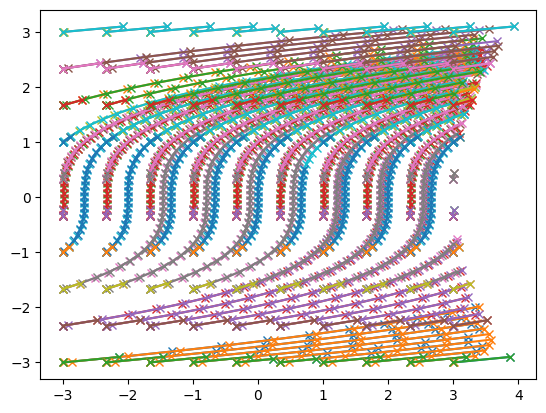

In [78]:
xs,ys,zs = np.linspace(-3,3,10), np.linspace(-3,3,10), np.linspace(-3,3,3)
pnts = np.array([[x,y,z] for x in xs for y in ys for z in zs])
field = lambda t, x: np.array([x[1]**2,1,1])
boundary = np.array([[-3,-3,-3],[3,3,3]])
tol = 1e-8
recurring_tol = 1e-1
trunmax = 0.1

for sp in pnts:
    rkdp = spint.DOP853(field, 0.0, sp, np.Inf, max_step=1e-1)
    ts = [0.0]
    rs = [rkdp.y]
    check_recurring= False
    trun0 = time.time()
    while time.time()-trun0 < trunmax:
        rkdp.step()
        if rkdp.h_abs > 1e10:
            rkdp.status = f"h_abs too large: {rkdp.h_abs}"
        if any(np.logical_or(rkdp.y < boundary[0], rkdp.y > boundary[1])):
            rkdp.status = "out of bounds"
        dis = np.sum((np.array(rs[0]) - rkdp.y)**2)
        if check_recurring and dis < recurring_tol**2:
            rkdp.status = "returned to start point"
        if dis > recurring_tol**2:
            check_recurring = True
        ts.append(rkdp.t)
        rs.append(rkdp.y)
        if rkdp.status != "running":
            break
    ts = np.array(ts)
    rs = np.array(rs)
    plt.plot(rs[:,0],rs[:,1],marker="x")
    print(">",end="")
plt.show()